In [ ]:
#We need to install tf version 2.15 for compatibility with this notebook (written in March 2024).
!pip uninstall tensorflow
!pip install tensorflow==2.15.0
!tensorflow --version

# Milestone Project 2 - Skim Lit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.  

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

**Resource:**
If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the github: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

## Confirm access to a GPU.

In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Get data

Since we'll be replicating the paper above (Pubmed 200k RCT), let's download the dataset they used.  

We can do so from the author's github: https://github.com/Franck-Dernoncourt/pubmed-rct



In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 14.88 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# Check what files are in the PubMed20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

# Check what files are in the PubMed200k dataset
#!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/



dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with numbers replaced by "@" symbols.
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


# Start our experiments using the 200k dataset with numbers replaced by @ symbols
#data_dir_200k = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the file paths in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

#unzip the train.zip from 200k
import zipfile

zip_path = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip"
extract_path = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_path)

#filenames_200k = [data_dir_200k + filename_200k for filename_200k in os.listdir(data_dir_200k)]
#filenames_200k

## Preprocess the data

Now that we've got some text data, it's time to become one with it.

One of the best ways to become one with the data is to...

>Visualize, visualize, visualize...

So with that in mind, let's write a function to read in all the lines of a target text file.

In [ ]:
# Create a function to read in all the lines of a document

def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: the string name containing the target file path

  Returns:
    A list of strings with 1 string per line from the target filename.
  """
  new_list = []

  with open(filename) as thefile:
    return thefile.readlines()



In [ ]:
train_lines = get_lines(filenames[1]) # read the lines from the training file
train_lines[:20]
#filenames_200k[2]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
# Read in all the lines of the 200k training file
#train_lines_200k = get_lines(filenames_200k[0])
#train_lines_200k[:10]

In [ ]:
len(train_lines)

210040

In [ ]:
#len(train_lines_200k)

Let's think about how we want our data to look...

How I think our data would be best represented:

```
[{'line_number':0,
  'target':'OBJECTIVE',
  'text':"To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .,
  'total_lines':12},
  ...]
```

In [ ]:
train_lines[2]

'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n'

In [ ]:
#for row in train_lines:
#train_lines[2]
my_dict = {}
my_dict["line_number"] = 2
my_dict["target"] = train_lines[2].split("\t")[0]
my_dict["text"] = train_lines[2].split("\t")[1]
print(my_dict)

{'line_number': 2, 'target': 'METHODS', 'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n'}


In [ ]:
my_dict = {}
my_list = []

for index, row in enumerate(train_lines):
  split_row = (train_lines[index].split("\t"))
  if (len(split_row)) > 1:
    #my_dict["line_number"] = index
    #my_dict["target"] = split_row
    my_list.append({"line_number":index,
                 "target":split_row[0],
                 "text":split_row[1],
                    "total_lines":index})
  #print(my_dict)
  #my_list.append({my_dict["line_number"]:my_dict["target"]})


print(my_list[:10])

[{'line_number': 1, 'target': 'OBJECTIVE', 'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n', 'total_lines': 1}, {'line_number': 2, 'target': 'METHODS', 'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n', 'total_lines': 2}, {'line_number': 3, 'target': 'METHODS', 'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n', 'total_lines': 3}, {'line_number': 4, 'target': 'METHODS', 'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .\n', 'total_lines': 4}, {'line_number': 5, 'target': 'METHODS', 'text': 'Secondary outcome measures included the Western Ontario and Mc

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data

  Takes in a filename, reads its contents, and sorts through each line, extracting things like target label, text of the sentences,
  how many sentences are in the current abstract, and what sentence number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # Create an empty abstract
  abstract_samples = [] # Create an empty list of abstracts

  #loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # Check to see if the line is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace():  # check to see if a line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # Create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # Split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the total abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 757 ms, sys: 184 ms, total: 941 ms
Wall time: 1.88 s


(180040, 30212, 30135)

In [ ]:
# Get data from file and preprocess it (200k)
%%time
#train_samples_200k = preprocess_text_with_line_numbers(data_dir_200k + "train.txt")
#val_samples_200k = preprocess_text_with_line_numbers(data_dir_200k + "dev.txt")
#test_samples_200k = preprocess_text_with_line_numbers(data_dir_200k + "test.txt")
#len(train_samples_200k), len(val_samples_200k), len(test_samples_200k)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [ ]:
# Check the first abstract of our training data
train_samples[200]

#train_samples_200k[200]

{'target': 'RESULTS',
 'text': 'thirty-seven individuals -lsb- interquartile range ( iqr ) cd@ cell counts at screening : @-@ cells/l ; undetectable hiv-@ viremia -rsb- were enrolled ; @ % of individuals reported previous bcg vaccination , @ % tested negative for the quantiferon-tb assay .',
 'line_number': 7,
 'total_lines': 11}

Now that our data is in the form of a list of dictionaries, let's turn it into a DataFrame to visualize it.

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
#train_200k_df = pd.DataFrame(train_samples_200k)
#val_200k_df = pd.DataFrame(val_samples_200k)
#test_200k_df = pd.DataFrame(test_samples_200k)
#train_200k_df.head(14)

In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

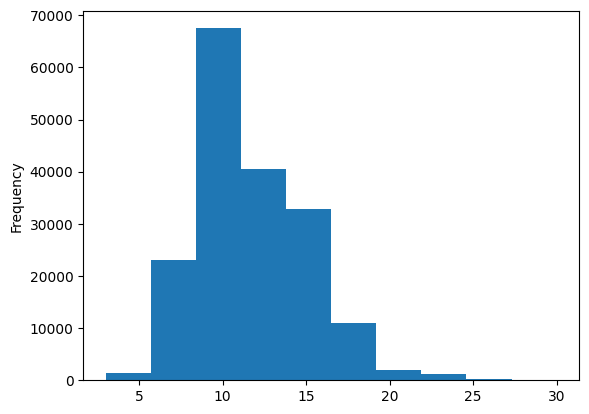

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

<Axes: ylabel='Frequency'>

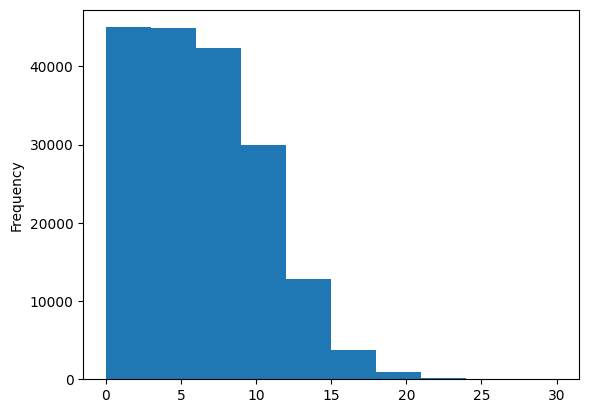

In [ ]:
train_df.line_number.plot.hist() # shows the total amount of each "line_number" in the whole dataframe

### Get lists of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

#200k sentences
#train_sentences_200k = train_200k_df["text"].tolist()
#val_sentences_200k = val_200k_df["text"].tolist()
#test_sentences_200k = test_200k_df["text"].tolist()

(180040, 30212, 30135)

In [ ]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
new_df = train_df.replace(["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"], [0,1,2,3,4])


In [ ]:
new_df[:30]

,target,text,line_number,total_lines
0,1,to investigate the efficacy of @ weeks of dail...,0,11
1,2,a total of @ patients with primary knee oa wer...,1,11
2,2,outcome measures included pain reduction and i...,2,11
3,2,pain was assessed using the visual analog pain...,3,11
4,2,secondary outcome measures included the wester...,4,11
5,2,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,3,there was a clinically relevant reduction in t...,6,11
7,3,the mean difference between treatment arms ( @...,7,11
8,3,"further , there was a clinically relevant redu...",8,11
9,3,these differences remained significant at @ we...,9,11


In [ ]:
# Add position percentage parameter to new_df
new_df["position_param"] = new_df["line_number"]/new_df["total_lines"]
new_df[:10]

,target,text,line_number,total_lines,position_param
0,1,to investigate the efficacy of @ weeks of dail...,0,11,0.000000
1,2,a total of @ patients with primary knee oa wer...,1,11,0.090909
2,2,outcome measures included pain reduction and i...,2,11,0.181818
3,2,pain was assessed using the visual analog pain...,3,11,0.272727
4,2,secondary outcome measures included the wester...,4,11,0.363636
5,2,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11,0.454545
6,3,there was a clinically relevant reduction in t...,6,11,0.545455
7,3,the mean difference between treatment arms ( @...,7,11,0.636364
8,3,"further , there was a clinically relevant redu...",8,11,0.727273
9,3,these differences remained significant at @ we...,9,11,0.818182


In [ ]:
train_position_param = []
train_position_param = train_df["line_number"]/train_df["total_lines"]

val_position_param = []
val_position_param = val_df["line_number"]/val_df["total_lines"]

test_position_param = []
test_position_param = test_df["line_number"]/test_df["total_lines"]

#train_position_param[-10:]
#val_position_param[:10]
#test_position_param[:10]

#train_position_param_200k = []
#train_position_param_200k = train_200k_df["line_number"]/train_200k_df["total_lines"]

#val_position_param_200k = []
#val_position_param_200k = val_200k_df["line_number"]/val_200k_df["total_lines"]

#test_position_param_200k = []
#test_position_param_200k = test_200k_df["line_number"]/test_200k_df["total_lines"]

In [ ]:
#train_200k_df[:10]

## Make numeric labels (ML models require numeric labels)



In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

# Check what one-hot-encoded labels look like
train_labels_one_hot
val_labels_one_hot
test_labels_one_hot

# One hot encode labels
#one_hot_encoder_200k = OneHotEncoder(sparse=False) # we want non-sparse matrix
#train_labels_one_hot_200k = one_hot_encoder.fit_transform(train_200k_df["target"].to_numpy().reshape(-1,1))
#val_labels_one_hot_200k = one_hot_encoder.transform(val_200k_df["target"].to_numpy().reshape(-1,1))
#test_labels_one_hot_200k = one_hot_encoder.transform(test_200k_df["target"].to_numpy().reshape(-1,1))

# Check what one-hot-encoded labels look like
#train_labels_one_hot_200k
#val_labels_one_hot_200k
#test_labels_one_hot_200k

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)
tf.constant(val_labels_one_hot)
tf.constant(test_labels_one_hot)

<tf.Tensor: shape=(30135, 5), dtype=float64, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Extract labels ("target" columns) and encode them into integers
#from sklearn.preprocessing import LabelEncoder
#label_encoder = LabelEncoder()
#train_labels_encoded_200k = label_encoder.fit_transform(train_200k_df["target"].to_numpy())
#val_labels_encoded_200k = label_encoder.transform(val_200k_df["target"].to_numpy())
#test_labels_encoded_200k = label_encoder.transform(test_200k_df["target"].to_numpy())


# Check what training labels look like
#train_labels_encoded_200k

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
# Create TF-IDF Naive Bayes encoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words into numbers using Tfidf
    ("clf", MultinomialNB())      #model the text
])

In [ ]:
# Fit the model
model_0.fit(train_sentences,
            train_labels_encoded
                              )

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score = model_0.score(val_sentences, val_labels_encoded)

In [ ]:
baseline_score

0.7218323844829869

## Starting a series of modelling experiments

As usual. we're going to be trying out a few different models and see which one works best.  As always we're going to start with a baselien - TfIDF Multinomial Naive Bayes Classifier

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download helper functions script
In the previous module we wrote a function to compare predictions across different metrics.  We want accuracy, precision, recall, and F1.  Rather than rewriting it here, let's download it from our helper function script.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-14 19:23:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-14 19:23:32 (99.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

baseline_results = calculate_results(val_labels_encoded,
                                     baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentences on average?

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

In [ ]:
# How long is each sentences on average? (200k)

#sent_lens = [len(sentence.split()) for sentence in train_sentences_200k]
#avg_sent_len = np.mean(sent_lens)
#avg_sent_len

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

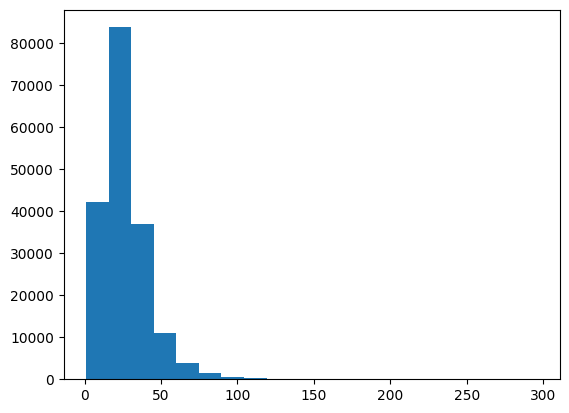

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length in the training set
max(sent_lens)

296

In [ ]:
# adding first text_vectorization layer to check if additional dimension added

#text_vectorizer = TextVectorization(max_tokens=10000,  # how many words in the vocabulary? (automatically add <OOV>)
#                                    standardize="lower_and_strip_punctuation",
#                                    split="whitespace",
#                                    ngrams=None, # create groups of n-words
#                                    output_mode="int", # how to map tokens to number
#                                    output_sequence_length=None,  # how long do you want your sequences to be?
#                                    pad_to_max_tokens=True)

### Create text vectorization layer

We want to make a layer which maps our texts from words to numbers

In [ ]:
# How many words are in our vocab? Taken from table 2 in:  https://arxiv.org/pdf/1710.06071.pdf



In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


# Setup text vectorization variables
max_vocab_length = 68000
max_length = 55

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length=output_seq_len)

In [ ]:
# Setup text vectorization variables
#max_vocab_length_200k = 331000
#max_length_200k = 54

#text_vectorizer_200k = TextVectorization(max_tokens=max_vocab_length_200k,
#                                        output_sequence_length=output_seq_len)

In [ ]:
# fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# fit the text vectorizer to the training text
#text_vectorizer_200k.adapt(train_sentences_200k)

In [ ]:
import random
# Create a sample sentence and tokenize it
sample_sentence = random.choice(train_sentences)
print(text_vectorizer([sample_sentence]))

tf.Tensor(
[[    6   164     2    70     4  2653   631   410 14729   396  6477    18
  15530  2754    78     3    47    86    11   306  1244 13506    34     7
   7858  5580  6832     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]], shape=(1, 55), dtype=int64)


In [ ]:
# How many words in our training vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most commmon words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most commmon words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [ ]:
# Create embedding
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128, # different embedding sizes result in drastically different numbers of parameters to train
                             input_length=max_length,
                             mask_zero=True,
                             name="token_embedding")

embedding

In [ ]:
import random

# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text: {random_sentence} \n\
Output sentence: ")
print(f"Vectorized sentence: {text_vectorizer(sample_sentence)}")
# Embed the random sentence (turn it into a dense vector of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
#sample_embed = tf.expand_dims(sample_embed, axis=0)
print(f"Embedded sentence shape: {sample_embed.shape}")
sample_embed


Original text: mean arterial pressure was maintained at @ to @ mm hg in controlled hypotensive anesthesia achieved using remifentanil infusion . 
Output sentence: 
Vectorized sentence: [    6   164     2    70     4  2653   631   410 14729   396  6477    18
 15530  2754    78     3    47    86    11   306  1244 13506    34     7
  7858  5580  6832     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]
Embedded sentence shape: (1, 55, 128)


<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[-0.02527878, -0.01285734,  0.00153945, ..., -0.0077898 ,
          0.03308659,  0.0199143 ],
        [-0.02120228, -0.01264145,  0.00765188, ..., -0.03680006,
          0.00717341, -0.00053886],
        [-0.0400396 , -0.0297521 ,  0.02011348, ..., -0.01500852,
         -0.01377923, -0.01778226],
        ...,
        [-0.0497687 ,  0.02806884,  0.02379957, ...,  0.03034158,
          0.00388819,  0.03346188],
        [-0.0497687 ,  0.02806884,  0.02379957, ...,  0.03034158,
          0.00388819,  0.03346188],
        [-0.0497687 ,  0.02806884,  0.02379957, ...,  0.03034158,
          0.00388819,  0.03346188]]], dtype=float32)>

In [ ]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0][0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.02527878, -0.01285734,  0.00153945, -0.01025848,  0.00349549,
         0.01196027,  0.01157703,  0.02779715,  0.045068  , -0.04092308,
        -0.00080166,  0.02418783,  0.0252185 , -0.03673976,  0.04428129,
         0.03785387,  0.02986908, -0.03880356,  0.02840035, -0.03074286,
         0.02391375,  0.00246534,  0.00230974,  0.02863337,  0.00700811,
        -0.00462519,  0.02511004, -0.0177825 ,  0.02987507,  0.01262874,
        -0.02281296,  0.00517521,  0.01125981,  0.01210253,  0.01864071,
         0.02758886, -0.0351873 ,  0.02382937,  0.00269951, -0.04945913,
         0.01092327,  0.01123961, -0.02733296, -0.0336797 , -0.01868639,
         0.04427672, -0.00033263, -0.01049209,  0.01788629, -0.03355002,
        -0.0363803 ,  0.0293339 ,  0.01230382,  0.04481468,  0.02387663,
        -0.03856816, -0.03835012,  0.00941264,  0.01801426,  0.02463504,
        -0.03446107, -0.01500673, -0.01298701, -0.04560144, -0.0036666 ,
  

## Model 1: Conv1D Model with Sentence Embeddings (tokens)

### Creating datasets (making sure our data loads as fast as possible)

We're going to set up our data to run as possible with the TensorFlow tf.data API.  Many of the steps here are discussed in these two resources:
https://www.tensorflow.org/guide/data_performance
https://www.tensorflow.org/guide/data

In [ ]:
# Turn our data into tensorflow datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot,train_position_param))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot, val_position_param))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot, test_position_param))

test_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [ ]:
# Testing: Can we add a third parameter for the dataset?

#train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot, train_labels_encoded))

#train_dataset

In [ ]:
# Take the TensorSliceDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
# Create a 1d Conv layer to model sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="same")(x)
x = layers.GlobalAveragePooling1D()(x)  #condense the output of our feature vector from conv layer
print(x.shape)
outputs=layers.Dense(5, activation="softmax",name="softmax")(x)
model_1 = tf.keras.Model(inputs,
                         outputs,
                         name="Model_1_Conv1D")

# Compile Conv1D
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

# Get a summary
model_1.summary()

(None, 64)
Model: "Model_1_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8704000   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                         

In [ ]:
#numpy_train_sentences = np.array(train_sentences, dtype=float)
#train_sentences[:10]
#train_sentences_numpy = np.asarray(train_sentences)
#val_sentences_numpy = np.asarray(val_sentences)
#train_labels_numpy = np.asarray(train_labels_encoded)
#val_labels_numpy = np.asarray(val_labels_encoded)

In [ ]:
#val_labels_numpy

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              epochs=1,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

562/562 [==============================] - ETA: 0s - loss: 0.4071 - accuracy: 0.5710

562/562 [==============================] - 120s 212ms/step - loss: 0.4071 - accuracy: 0.5710 - val_loss: 0.2867 - val_accuracy: 0.6855


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.2842 - accuracy: 0.6882


[0.28415557742118835, 0.6882033348083496]

In [ ]:
# make predictions (our model makes prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 6s 6ms/step


(array([[4.79614586e-02, 8.26231897e-01, 3.04305684e-02, 2.27575600e-02,
         7.26185441e-02],
        [1.13000326e-01, 8.26864064e-01, 1.36737442e-02, 1.78536884e-02,
         2.86081731e-02],
        [4.46872786e-02, 8.22283685e-01, 6.97619915e-02, 3.74552645e-02,
         2.58115921e-02],
        ...,
        [3.93560003e-05, 5.39590325e-03, 8.37745890e-03, 2.51206831e-04,
         9.85936046e-01],
        [6.04983466e-03, 6.77672148e-01, 3.93799879e-02, 1.64687373e-02,
         2.60429323e-01],
        [4.43922102e-01, 4.07173932e-01, 7.90155604e-02, 2.46654898e-02,
         4.52228151e-02]], dtype=float32),
 (30212, 5))

In [ ]:
# Convert pred_probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 1, 0])>

In [ ]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 68.8203362902158,
 'precision': 0.6844571774884642,
 'recall': 0.6882033629021581,
 'f1': 0.6562097092062448}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Create sentence encoder layer like the one used in the paper PubMed 200k RCT.

Using USE from Kaggle: https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2

The paper originally used GloVe embeddings but we will use the USE from Kaggle

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")


In [ ]:
# Create Keras layer from pretrained TF Hub layer from kaggle

sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")


In [ ]:
# test out our USE feature extraction model on a random sentence

random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: {random_train_sentence}")
use_embedded_sentence = sentence_encoder_layer([random_train_sentence])
use_embedded_sentence[0][:30], len(use_embedded_sentence[0])

Random sentence: driving simulator performance and reaction time also improved on modafinil .


(<tf.Tensor: shape=(30,), dtype=float32, numpy=
 array([ 0.03825735, -0.01983187,  0.03384233, -0.0007863 , -0.00199978,
         0.07256199, -0.02581286, -0.06671463,  0.05806025,  0.06239573,
         0.01616853,  0.06994236,  0.05749549, -0.02860614, -0.00787395,
        -0.04195068, -0.07216883, -0.05784975,  0.03311549, -0.04800161,
         0.00717531, -0.02625331, -0.06110667, -0.00621275,  0.05586251,
        -0.04155371, -0.00384095,  0.03279176, -0.07414366, -0.04132678],
       dtype=float32)>,
 512)

## Create a model using GloVe embeddings ##

In [ ]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-03-14 19:28:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2024-03-14 19:31:37 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
#Let's make a dict mapping words (strings) to their NumPy vector representation:

path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embeddings_index["jennicam"]

array([ 0.4373   , -0.52083  , -0.13275  , -0.054739 ,  0.047666 ,
       -0.1588   ,  0.10456  , -0.071002 ,  0.31034  , -0.19484  ,
        0.26969  ,  0.45522  , -0.17371  , -0.45058  , -0.33439  ,
        0.35471  ,  0.11824  ,  0.14107  ,  0.20165  ,  0.35314  ,
       -0.33931  ,  0.14092  , -0.28308  , -0.030526 , -0.20683  ,
        0.12508  ,  0.13121  , -0.0074268,  0.044033 ,  0.067589 ,
        0.49297  , -0.21059  ,  0.46545  ,  0.061869 ,  0.052337 ,
       -0.38501  , -0.17532  , -0.52243  , -0.0034452,  0.03187  ,
        0.49394  ,  0.70037  ,  0.27976  ,  0.41316  , -0.15494  ,
        0.064294 , -0.36409  ,  0.58317  ,  0.009442 ,  0.29351  ,
        0.30784  ,  0.27724  , -0.062266 , -0.49913  ,  0.10559  ,
        0.50963  ,  0.27195  ,  0.5948   , -0.23056  , -0.26474  ,
       -0.10429  , -0.29151  ,  0.24206  , -0.10555  , -0.086396 ,
       -0.097096 , -0.5984   , -0.031902 , -0.17148  , -0.28393  ,
        0.24964  ,  0.39844  , -0.0081099,  0.29213  , -0.1868

In [ ]:
# Now let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer

# How many words in our training vocab
num_tokens = len(rct_20k_text_vocab) + 2
embedding_dim = 100
hits = 0
misses = 0

word_index = dict(zip(rct_20k_text_vocab, range(len(rct_20k_text_vocab))))

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 29730 words (35111 misses)


## Model 2: Sentence embeddings and USE layer

In [ ]:

# Build the model
model_2 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(5, activation="softmax", name='output_layer'),
], name="MODEL_2_USE")


In [ ]:
# Compile model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

In [ ]:

model_2.summary()

In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.2*(len(train_dataset))),
                              epochs=3,
                              validation_data=(valid_dataset),
                              validation_steps=int(0.2*(len(valid_dataset))))

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

In [ ]:
model_2_preds[:30]

In [ ]:
len(model_2_preds)

In [ ]:
class_names

In [ ]:
model_2.evaluate(valid_dataset)

In [ ]:
# Calculate results from TF Hub pretrained embeddings on validation set
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

In [ ]:
baseline_results

In [ ]:
model_1_results

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character level embeddings.  Previously we've made token-level embeddings, but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character-level tokenizer

In [ ]:
train_sentences[:5]

In [ ]:
# Make function to split sentences into characters

def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level-sequence into characters
split_chars(random_train_sentence)

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

In [ ]:
# What's the average character length?
chars_lens = [len(sentence) for sentence in train_sentences]
chars_lens[:10]

mean_char_len = np.mean(chars_lens)
mean_char_len

In [ ]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(chars_lens, bins=7)

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet



In [ ]:
random.choice(train_sentences)

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (out of vocab)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None,
                                    name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()

In [ ]:
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 Most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text: \n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

### Create character-level embedding layers (tip: it's very similar to token-level embedding)

In [ ]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                                  output_dim=25,              #this is the size of the char embedding in https://arxiv.org/pdf/1612.05251.pdf (Figure 1)
                                  #input_length=output_seq_len,
                                  mask_zero=True,
                                  name="char_embed")

In [ ]:
# Test our character embedding layer
print(f"Charified text: \n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (After vectorization and embedding): \n {char_embed_example} \n")
print(f"Character embedding shape: {char_embed_example.shape}")

### Model 3: Character-level embedding

In [ ]:
# Create a 1d Conv layer to model sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="same")(x)
x = layers.GlobalMaxPool1D()(x) # Condense the output of our feature vector from conv layer
print(x.shape)
outputs=layers.Dense(5, activation="softmax", name="softmax")(x)
model_3 = tf.keras.Model(inputs,
                         outputs,
                         name="Model_3_Conv1D")

# Build the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

# Fit the model
#history_model_3_sentences = model_3.fit(train_dataset,
#                             steps_per_epoch=(int(0.2*len(train_dataset))),
#                             epochs=3,
#                             validation_data=valid_dataset,
#                             validation_steps=(int(0.2*len(valid_dataset))))

In [ ]:
model_3.summary()

In [ ]:
# Create chars datasets

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Fit the model on chars only
history_model_3 = model_3.fit(train_char_dataset,
                              steps_per_epoch=(int(0.2*(len(train_char_dataset)))),
                              epochs=3,
                              validation_data=valid_char_dataset,
                              validation_steps=int(0.2*(len(valid_char_dataset))))

In [ ]:
# Make predictions with character model only

model_3_pred_probs = model_3.predict(valid_char_dataset)

In [ ]:
model_3_pred_probs

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds[:10]

In [ ]:
val_labels_encoded

In [ ]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

In [ ]:
baseline_results

## Model 4: Combining Pre-trained Token Embeddings + Character embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar to model 1)
2. Create a character-level model (similar to model 3, with a slight modification)
3. Combine 1 and 2 with a concatenate layer (`layers.Concatenate`)
4. Build a series of output layers on top of 3 (similar to Figure 1 and section 4.2 of this paper: https://arxiv.org/pdf/1612.05251.pdf )
5. Construct a model which takes token and character-level sequences as input and produces sequence-label probabilities as outputs.


In [ ]:
#1. Create token-level embedding

# Setup text vectorization variables
max_vocab_length = 68000
max_length = 55

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length=output_seq_len)


In [ ]:
# fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)


In [ ]:
# Create embedding (token-level)
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128, # different embedding sizes result in drastically different numbers of parameters to train
                             input_length=max_length,
                             mask_zero=True,
                             name="token_embedding")

embedding

In [ ]:
# 1. Create a token-level model (similar to model_1)
inputs = layers.Input(shape=[], dtype=tf.string)
token_embeddings = sentence_encoder_layer(inputs)
#x = text_vectorizer(inputs)
#x = embedding(x)
#x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="same")(x)
#x = layers.GlobalAveragePooling1D()(x)  #condense the output of our feature vector from conv layer
#print(x.shape)
outputs=layers.Dense(128, activation="softmax",name="softmax")(token_embeddings)
token_model = tf.keras.Model(inputs,
                         outputs,
                         name="Token_Model")

# Compile Conv1D
token_model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

# Get a summary
token_model.summary()

In [ ]:
# 2. Create character-level embedding

# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (out of vocab)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None,
                                    name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Create char embedding

char_embed = layers.Embedding(input_dim=len(char_vocab),
                                  output_dim=25,              #this is the size of the char embedding in https://arxiv.org/pdf/1612.05251.pdf (Figure 1)
                                  #input_length=output_seq_len,
                                  mask_zero=True,
                                  name="char_embed")

In [ ]:
# 2b - Create a character-level model (similar to model 3, with a slight modification)

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="same")(x)
x = layers.GlobalMaxPool1D()(x) # Condense the output of our feature vector from conv layer
#char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(x)  #Bi-LSTM shown in figure 1 of: https://arxiv.org/pdf/1612.05251.pdf
print(x.shape)
outputs=layers.Dense(5, activation="softmax", name="softmax2")(x)
char_model = tf.keras.Model(inputs,
                         outputs,
                         name="char_model")

# Build the model
char_model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

In [ ]:
# 3. Concatenate token and char inputs (create hybrid token embedding)

concat_layer = layers.Concatenate(name="token_char_hybrid")([char_model.output, token_model.output])
concat_layer

In [ ]:
# 4. Create ouput layers, adding in Dropout - discussed in Section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(concat_layer)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [ ]:
# 5. Construct model with char and token inputs

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

model_4.summary()

In [ ]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)


In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), #Section 4.2 of the paper states they use SGD.  You might want to try this
                metrics="accuracy")


### Combining token and character data into a tf.data Dataset

In [ ]:
# Challenge: Turn out token inputs and char inputs into a TF dataset

train_combined_dataset = tf.data.Dataset.from_tensor_slices(((train_sentences, train_chars),train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_combined_dataset = tf.data.Dataset.from_tensor_slices(((val_sentences, val_chars), val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_combined_dataset = tf.data.Dataset.from_tensor_slices(((test_sentences, test_chars), test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)





In [ ]:
# Check out training char and token embedding dataset + position params
train_combined_dataset

### Fitting Model 4 on token and char level sequences


In [ ]:
history_model_4 = model_4.fit(train_combined_dataset,
                    epochs=3,
                    steps_per_epoch=int(0.1*len(train_combined_dataset)),
                    validation_data=valid_combined_dataset,
                    validation_steps=int(0.1*len(valid_combined_dataset)))

In [ ]:
model_4.evaluate(valid_combined_dataset)

In [ ]:
model_4_pred_probs = model_4.predict(valid_combined_dataset)

In [ ]:
model_4_pred_probs

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

In [ ]:
model_4_preds

In [ ]:
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_preds)

In [ ]:
model_4_results

In [ ]:
baseline_results

### Model 5: Make token embedding + character embedding + positional embedding layer

My idea: create new positional model, then use layers.Concatenate with model_4.input and model_4.output

In [ ]:
# Build datasets along with char inputs and token inputs plus position_params

train_combined_dataset_pp = tf.data.Dataset.from_tensor_slices(((train_sentences, train_chars, train_position_param), train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_combined_dataset_pp = tf.data.Dataset.from_tensor_slices(((val_sentences, val_chars, val_position_param), val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_combined_dataset_pp = tf.data.Dataset.from_tensor_slices(((test_sentences, test_chars, test_position_param), test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_combined_dataset_pp

new_pubmed_dataset = tf.data.Dataset.from_tensor_slices(test_sentences).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# 2b - Create a position_paramater-level model

inputs = layers.Input(shape=(1,), dtype=tf.float64)
#x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="same")(inputs)
x = layers.Dense(64, activation="relu")(inputs)
#x = layers.GlobalMaxPool1D()(x) # Condense the output of our feature vector from conv layer
#char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(x)  #Bi-LSTM shown in figure 1 of: https://arxiv.org/pdf/1612.05251.pdf
print(x.shape)
outputs=layers.Dense(5, activation="softmax", name="softmax3")(x)
pp_model = tf.keras.Model(inputs,
                          outputs,
                          name="pp_model")

# Build the model
pp_model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

In [ ]:
# 3. Concatenate token and char inputs (create hybrid token embedding)

concat_layer = layers.Concatenate(name="token_char_pp_hybrid")([token_model.output,
                                                                char_model.output,
                                                                pp_model.output])
concat_layer

In [ ]:
# 4. Create ouput layers, adding in Dropout - discussed in Section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(concat_layer)
combined_dense = layers.Dense(256, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [ ]:
#5. Construct model with char and token and position_param inputs

model_5 = tf.keras.Model(inputs=[token_model.input, char_model.input, pp_model.input],
                         outputs=output_layer,
                         name="model_5_token_char_pp_embeddings")

model_5.summary()

In [ ]:
# Plot hybrid token and character and position_param model
from keras.utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high) it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn hopefully improving generalization:
`[0.01, 0.01, 0.96, 0.01, 0.01]`

In [ ]:
# compile model 5
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

# fit the model
history_model_5 = model_5.fit(train_combined_dataset_pp,
                              epochs=3,
                              steps_per_epoch=int(0.1*(len(train_combined_dataset_pp))),
                              validation_data=valid_combined_dataset_pp,
                              validation_steps=int(0.1*(len(valid_combined_dataset_pp))))

In [ ]:
model_5.evaluate(valid_combined_dataset_pp)

In [ ]:
model_5_pred_probs = model_5.predict(valid_combined_dataset_pp)

In [ ]:
model_5_pred_probs

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)

In [ ]:
model_5_preds

In [ ]:
len(valid_combined_dataset_pp)

In [ ]:
model_5_results = calculate_results(val_labels_encoded,
                                    model_5_preds)

In [ ]:
model_5_results

In [ ]:
baseline_results

In [ ]:
train_combined_dataset_pp

## Combined Results

In [ ]:
# Combine results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline":baseline_results,
                                  "model_1_custom_token_embedding":model_1_results,
                                  "model_2_pretrained_token_embedding":model_2_results,
                                  "model_3_custom_char_embedding":model_3_results,
                                  "model_4_hybrid_char_token_embedding":model_4_results,
                                  "model_5_pos_char_token_embedding":model_5_results})

all_model_results = all_model_results.transpose()
all_model_results


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [ ]:
all_model_results

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind="bar",
                       figsize=(10,7)).legend(bbox_to_anchor(1.0, 1.0))

In [ ]:
# Sort model results by F1 scores
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7))

# Save and load model 5

In [ ]:
model_5.save("model_5_saved")

In [ ]:
# load in best performing model
loaded_model_5 = tf.keras.models.load_model("model_5_saved")

In [ ]:
loaded_model_5.evaluate(valid_combined_dataset_pp)

In [ ]:
loaded_model_5_pred_probs = loaded_model_5.predict(valid_combined_dataset_pp)
loaded_model_5_pred_probs

In [ ]:
loaded_model_5_preds = tf.argmax(loaded_model_5_pred_probs, axis=1)

In [ ]:
loaded_model_5_preds

In [ ]:
loaded_model_5_results = calculate_results(val_labels_encoded,
                                           loaded_model_5_preds)

In [ ]:
loaded_model_5_results

In [ ]:
model_5_results

In [ ]:
model_5_results == loaded_model_5_results

In [ ]:
# Check the loaded model summary
loaded_model_5.summary()

## Download and load in a pretrained model from Google Storage

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model

In [ ]:
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

In [ ]:
# Load in downloaded GS model
loaded_gs_model = tf.keras.models.load_model("skimlit_gs_model/skimlit_tribrid_model/")

## Your challenges
1. Turn the test data samples into a tf.data dataset for fast loading
2. Find the most wrong predictions from 1. (these are the samples where the model has predicted the wrong label with the highest prediction probability).
3. Make example predictions (on RCT abstracts from the wild), you can go to PubMed https://pubmed.ncbi.nlm.nih.gov/ find and use our model to predict on 3-4 different abstracts from the wild.  
* Some examples: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
4. See the exercises and extra curriculum section on GitHub to further test your skills (for section 9)


In [ ]:
# 1. Test data samples for fast loading created in our previous model
test_combined_dataset_pp

In [ ]:
# 2.
loaded_model_5_pred_probs = loaded_model_5.predict(test_combined_dataset_pp)

In [ ]:
loaded_model_5_pred_probs[:15]

In [ ]:
loaded_model_5_pred_probs.shape

In [ ]:
loaded_model_5_preds_highest = tf.math.reduce_max(loaded_model_5_pred_probs,axis=1)
loaded_model_5_preds_highest[:10]

In [ ]:
loaded_model_5_preds = tf.argmax(loaded_model_5_pred_probs, axis=1)

In [ ]:
loaded_model_5_preds[:10]

In [ ]:
test_labels_encoded

In [ ]:
loaded_model_5_results = calculate_results(test_labels_encoded,
                                           loaded_model_5_preds)

In [ ]:
loaded_model_5_results

In [ ]:
import pandas as pd

my_new_dataframe = pd.DataFrame({"text":test_sentences,
                                 "y_true":test_labels_encoded,
                                 "y_pred":loaded_model_5_preds,
                                 "confidence":loaded_model_5_preds_highest})

my_new_dataframe["pred_correct"] = my_new_dataframe["y_true"] == my_new_dataframe["y_pred"]
my_new_dataframe

In [ ]:
#create top 100 wrong predictions data frame
top_100_wrong = my_new_dataframe[my_new_dataframe["pred_correct"]==False].sort_values("confidence", ascending=False)[:100]
top_100_wrong

In [ ]:
# replace numbers with label names for y_true and y_pred
top_100_wrong = top_100_wrong.replace([0,1,2,3,4], ["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"])
top_100_wrong

In [ ]:
# Create predictions on dataset without labels
loaded_model_5_new_pubmed_pred_probs = model_3.predict(new_pubmed_dataset)

In [ ]:
#simpler preprocessing function for our abstract downloaded from pubmed without labels and other info, just sentences (Green Tea Abstract)

def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data

  Takes in a filename, reads its contents, and sorts through each line, extracting things like target label, text of the sentences,
  how many sentences are in the current abstract, and what sentence number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # Create an empty abstract
  abstract_samples = [] # Create an empty list of abstracts
  total_lines = []

  #loop through each line in the target file
  #for line in input_lines:
  #  total_lines.append(line)
    #if line.startswith("###"): # Check to see if the line is an ID line
    #  abstract_id = line
    #  abstract_lines = "" # reset the abstract string if the line is an ID line
    #if line.isspace():  # check to see if a line is a new line
    #  abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
    #  for abstract_line_number, abstract_line in enumerate(abstract_line_split):
    #    line_data = {} # Create an empty dictionary for each line
        #target_text_split = abstract_line.split("\t") # Split target label from text
        #line_data["target"] = target_text_split[0] # get target label
        #line_data["text"] = target_text_split[1].lower() # get target text and lower it
    #    line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
    #    line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the total abstract? (start from 0)
    #    abstract_samples.append(line_data) # add line data to abstract samples list

    #else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
    #  abstract_lines += line

  #return sentences
  return input_lines
  #return abstract_samples

In [ ]:
#simpler preprocessing function for our abstract downloaded from pubmed without labels and other info, just sentences (Green Tea Abstract)
# using regular expressions to split only when the character "." is not preceded by an uppercase letter or ]
import re

def preprocess_text_with_line_numbers2(filename):


  def custom_split(input_string):
    # Define the regular expression pattern
    pattern = r'(?<=[^A-Z])\.'

    # Use re.split() with the pattern
    result = re.split(pattern, input_string)

    return result

  with open(filename, 'r') as file:
    # Read the content of the file
    content = file.read()

    output_string = custom_split(content)
    return output_string




  #return string_list

In [ ]:
pubmed_sample = preprocess_text_with_line_numbers2("green_tea_abstract_utf8.txt")

In [ ]:
len(pubmed_sample)

In [ ]:
pubmed_sample[:5]

In [ ]:
model_2_npm_samples_pred_probs = model_2.predict(pubmed_sample)

In [ ]:
model_2_npm_samples_preds = tf.argmax(model_2_npm_samples_pred_probs,axis=1)

In [ ]:
model_2_npm_samples_preds[0],pubmed_sample[0]

In [ ]:
new_pubmed_samples_df = pd.DataFrame({"sentence":pubmed_sample,
                                      "pred":model_2_npm_samples_preds})

In [ ]:
new_pubmed_samples_df.replace([0,1,2,3,4], ["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"])

In [ ]:
curcuma_dataset = preprocess_text_with_line_numbers2("curcuma_utf8.txt")
curcuma_dataset[:30]

In [ ]:
len(curcuma_dataset)

In [ ]:
model_2_curcuma_pred_probs = model_2.predict(curcuma_dataset)
model_2_pred_probs

In [ ]:
model_2_preds = tf.argmax(model_2_curcuma_pred_probs,axis=1)

In [ ]:
model_2_preds

In [ ]:
curcuma_dataset_df = pd.DataFrame({"sentence":curcuma_dataset,
                                   "pred":model_2_preds})
curcuma_dataset_df.replace([0,1,2,3,4], ["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"])